In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best-unset-model/best_unet_model.pth
/kaggle/input/best-unset-model/wandb/run-20250804_203306-wpi28i7d/run-wpi28i7d.wandb
/kaggle/input/best-unset-model/wandb/run-20250804_203306-wpi28i7d/logs/debug.log
/kaggle/input/best-unset-model/wandb/run-20250804_203306-wpi28i7d/logs/debug-internal.log
/kaggle/input/best-unset-model/wandb/run-20250804_203306-wpi28i7d/files/wandb-summary.json
/kaggle/input/best-unset-model/wandb/run-20250804_203306-wpi28i7d/files/config.yaml
/kaggle/input/best-unset-model/wandb/run-20250804_203306-wpi28i7d/files/output.log
/kaggle/input/best-unset-model/wandb/run-20250804_203306-wpi28i7d/files/requirements.txt
/kaggle/input/best-unset-model/wandb/run-20250804_203306-wpi28i7d/files/wandb-metadata.json
/kaggle/input/best-unset-model/wandb/run-20250804_203306-wpi28i7d/files/media/images/validation_examples_34_772f1d0bc01dd6752f4e.png
/kaggle/input/best-unset-model/wandb/run-20250804_203306-wpi28i7d/files/media/images/validation_examples_249_290ab798b86d

In [2]:
# ===================================================================
# CELL 1: SETUP AND CLASS DEFINITIONS
# ===================================================================
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import json
import os
import random

# You must define the model's architecture exactly as it was during training
# so that PyTorch can load the saved weights into it.

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels: mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x): return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x): return self.conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, n_channels, n_classes, num_colors, embedding_dim=32, bilinear=True):
        super(ConditionalUNet, self).__init__()
        self.color_embedding = nn.Embedding(num_colors, embedding_dim)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.bottleneck_proj = nn.Linear((1024 // factor) + embedding_dim, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, image, color_idx):
        x1 = self.inc(image)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        color_emb = self.color_embedding(color_idx)
        pooled_features = torch.mean(x5, dim=[2, 3])
        combined_vec = torch.cat([pooled_features, color_emb], dim=1)
        projected_vec = self.bottleneck_proj(combined_vec)
        conditioned_x5 = x5 + projected_vec.unsqueeze(-1).unsqueeze(-1)
        x = self.up1(conditioned_x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return torch.sigmoid(logits)

print("Model class definitions are ready.")

Model class definitions are ready.


In [3]:
# ===================================================================
# CELL 2: LOAD MODEL AND PREPARE FOR INFERENCE
# ===================================================================

# --- Configuration ---
IMAGE_SIZE = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Paths ---
# !! IMPORTANT: Adjust these paths based on your Kaggle input directories !!
DATASET_PATH = "/kaggle/input/ayna-ml-polygon-dataset/dataset/"
# !! Replace 'ayna-ml-training-output' with the actual name of your model output folder !!
MODEL_PATH = "/kaggle/input/best-unset-model/best_unet_model.pth" 

# --- Create the Color Mapping ---
# It's crucial that this mapping is identical to the one used during training.
# We can rebuild it by reading the training JSON file.
TRAIN_JSON_PATH = os.path.join(DATASET_PATH, 'training', 'data.json')
with open(TRAIN_JSON_PATH, 'r') as f:
    train_records = json.load(f)
all_colors = sorted(list(set(item['colour'] for item in train_records)))
color_to_idx = {name: i for i, name in enumerate(all_colors)}
NUM_COLORS = len(all_colors)

print(f"Using device: {DEVICE}")
print(f"Found {NUM_COLORS} colors: {list(color_to_idx.keys())}")

# --- Instantiate and Load the Model ---
# Initialize the model with the same parameters as during training
model = ConditionalUNet(n_channels=1, n_classes=3, num_colors=NUM_COLORS).to(DEVICE)

# Load the saved weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(DEVICE)))

# Set the model to evaluation mode (important for batchnorm, dropout, etc.)
model.eval()

print("\nModel loaded successfully and is ready for inference.")

# --- Define Image Transforms ---
# Must be the same as the validation transforms during training
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

Using device: cuda
Found 8 colors: ['blue', 'cyan', 'green', 'magenta', 'orange', 'purple', 'red', 'yellow']

Model loaded successfully and is ready for inference.


In [4]:
# ===================================================================
# CELL 3: PREDICTION FUNCTION
# ===================================================================

def predict_color(image_path, color_name):
    """
    Takes an input polygon image and a color name, and returns the generated image.
    """
    if color_name not in color_to_idx:
        raise ValueError(f"Color '{color_name}' is not a valid color. Choose from: {list(color_to_idx.keys())}")

    # Set model to evaluation mode
    model.eval()
    
    # 1. Load and preprocess the input image
    input_image = Image.open(image_path).convert("L") # Convert to grayscale
    input_tensor = transform(input_image).unsqueeze(0) # Add batch dimension
    input_tensor = input_tensor.to(DEVICE)
    
    # 2. Prepare the color index
    color_index = torch.tensor([color_to_idx[color_name]], dtype=torch.long).to(DEVICE)
    
    # 3. Perform inference
    with torch.no_grad(): # No need to calculate gradients
        output_tensor = model(input_tensor, color_index)
        
    # 4. Post-process the output tensor back to an image
    # Remove the batch dimension, move to CPU, and convert to a NumPy array for plotting
    output_image = output_tensor.squeeze(0).cpu().permute(1, 2, 0).numpy()
    
    return input_image, output_image

--- Running prediction for: octagon.png with color 'blue' ---


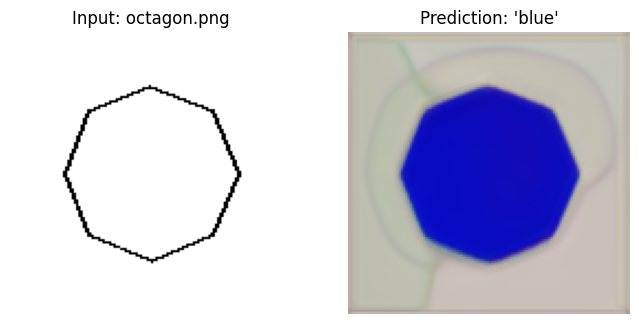

--- Running prediction for: square.png with color 'cyan' ---


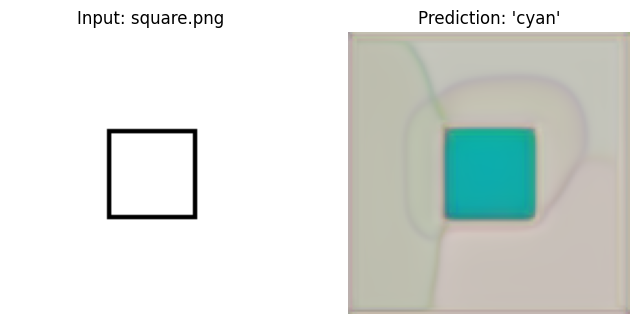

--- Running prediction for: triangle.png with color 'green' ---


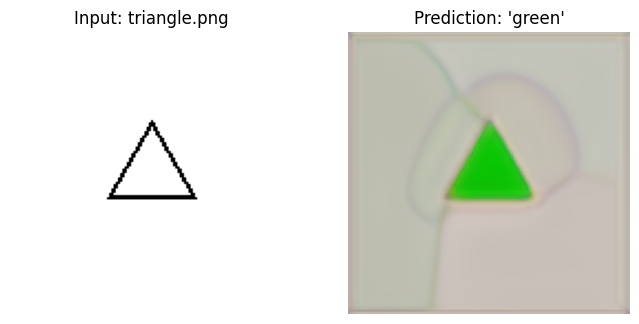

In [5]:
# ===================================================================
# CELL 4: VISUALIZE PREDICTIONS
# ===================================================================

# Get a few random examples from the validation set to test on
VAL_DIR = os.path.join(DATASET_PATH, 'validation')
VAL_JSON_PATH = os.path.join(VAL_DIR, 'data.json')
with open(VAL_JSON_PATH, 'r') as f:
    val_records = json.load(f)

# Let's test 3 random examples
for test_sample in random.sample(val_records, 3):
    image_name = test_sample['input_polygon']
    color_name = test_sample['colour']
    
    image_path = os.path.join(VAL_DIR, 'inputs', image_name)
    
    print(f"--- Running prediction for: {image_name} with color '{color_name}' ---")
    
    # Get the original input and the predicted output
    original_img, predicted_img = predict_color(image_path, color_name)
    
    # Display the results
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].imshow(original_img, cmap='gray')
    ax[0].set_title(f"Input: {image_name}")
    ax[0].axis('off')
    
    ax[1].imshow(predicted_img)
    ax[1].set_title(f"Prediction: '{color_name}'")
    ax[1].axis('off')
    
    plt.show()